In [2]:
import os
import torch
import argparse
import glob
import math
import random
import numpy as np
import pandas as pd
import tqdm as tqdm
from scipy.special import softmax
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from captum.attr import visualization

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from BERT_explainability.modules.BERT.BertForSequenceClassification import BertForSequenceClassification


###mods
import time

In [3]:
import datasets
from datasets import load_dataset, load_metric 
from datasets import list_datasets, list_metrics

In [4]:
# load model   
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-MNLI").to("cuda")
model.eval()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-MNLI")

In [5]:
dataset = "glue"
task = "mnli" # select a task
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
special_tokens = {101,102}    
sentence1_key, sentence2_key = task_to_keys[task]

mnli = load_dataset(dataset, task)

Found cached dataset glue (/home/anwbw/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, padding=False, max_length=tokenizer.model_max_length, truncation=True)
    
       # Map labels to IDs (not necessary for GLUE tasks)
    if "label" in examples:
        result["label"] = examples["label"]

    return result

In [7]:
tokenized_mnli = mnli.map(preprocess_function, batched=True, remove_columns=mnli["train"].column_names)

Loading cached processed dataset at /home/anwbw/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-efd8d860162b226b.arrow
Loading cached processed dataset at /home/anwbw/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-7f04ef593885d7aa.arrow
Loading cached processed dataset at /home/anwbw/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-045fb221679771db.arrow
Loading cached processed dataset at /home/anwbw/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-a0dde9fda687970e.arrow


Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [8]:
special_tokens = {101,102}    
mask = "[PAD]"
mask_id = 0   

In [10]:
def preprocess_sample(tokenized_mnli,index):
    input_ids = tokenized_mnli['validation_matched'][index]['input_ids']
    text_ids = (torch.tensor([input_ids])).to("cuda")
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0])
    
    att_mask = tokenized_mnli['validation_matched'][index]['attention_mask']
    special_idxs = [x for x, y in list(enumerate(input_ids)) if y in special_tokens]
    att_mask = [0 if index in special_idxs else 1 for index, item in enumerate(att_mask)]
    att_mask = (torch.tensor([att_mask])).to("cuda")
    label = tokenized_mnli['validation_matched'][index]['label']
    
    return text_ids, att_mask, text_words, label

In [11]:
def preprocess_instance(instance):
    input_ids = instance['input_ids']
    text_ids = (torch.tensor([input_ids])).to("cuda")
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0])
    
    att_mask = instance['attention_mask']
    special_idxs = [x for x, y in list(enumerate(input_ids)) if y in special_tokens]
    att_mask = [0 if index in special_idxs else 1 for index, item in enumerate(att_mask)]
    att_mask = (torch.tensor([att_mask])).to("cuda")
    label = instance['label']
    
    return text_ids, att_mask, text_words, label

In [12]:
# compute rollout between attention layers
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
        
    return joint_attention

In [13]:
class Generator:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    
    def generate_TransCAM(self, input_ids, attention_mask,
                          index=None, start_layer=0):

        result = self.model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        
        output = result[0]
        hs = result[1]

        kwargs = {"alpha": 1}

        blocks = self.model.bert.encoder.layer

        for blk_id in range(len(blocks)):
            hs[blk_id].retain_grad()

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cams = {}
        for blk_id in range(len(blocks)):
            hs_grads = hs[blk_id].grad
            
            att = blocks[blk_id].attention.self.get_attn().squeeze(0)
            att = att.mean(dim=0)
            att = att.mean(dim=0)
            
            cat = (hs_grads * hs[blk_id]).sum(dim=-1).squeeze(0)
            cat = cat * att
            cams[blk_id] = cat
            
        trans_expln = sum(cams.values())

        return trans_expln

    def generate_LRP(self, input_ids, attention_mask,
                     index=None, start_layer=11):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cams = []
        blocks = self.model.bert.encoder.layer
        for blk in blocks:
            grad = blk.attention.self.get_attn_gradients()
            cam = blk.attention.self.get_attn_cam()
            cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
            grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
            cam = grad * cam
            cam = cam.clamp(min=0).mean(dim=0)
            cams.append(cam.unsqueeze(0))
        rollout = compute_rollout_attention(cams, start_layer=start_layer)
        rollout[:, 0, 0] = 0
        return rollout[:, 0]


    def generate_LRP_last_layer(self, input_ids, attention_mask,
                     index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}
        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn_cam()[0]
        cam = cam.clamp(min=0).mean(dim=0).unsqueeze(0)
        cam[:, 0, 0] = 0
        return cam[:, 0]

    def generate_full_lrp(self, input_ids, attention_mask,
                     index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        cam = self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)
        cam = cam.sum(dim=2)
        cam[:, 0] = 0
        return cam

    def generate_attn_last_layer(self, input_ids, attention_mask,
                     index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn()[0]
        cam = cam.mean(dim=0).unsqueeze(0)
        cam[:, 0, 0] = 0
        return cam[:, 0]

    def generate_rollout(self, input_ids, attention_mask, start_layer=0, index=None):
        self.model.zero_grad()
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        blocks = self.model.bert.encoder.layer
        all_layer_attentions = []
        for blk in blocks:
            attn_heads = blk.attention.self.get_attn()
            avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
            all_layer_attentions.append(avg_heads)
        rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
        rollout[:, 0, 0] = 0
        return rollout[:, 0]

    def generate_attn_gradcam(self, input_ids, attention_mask, index=None):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        kwargs = {"alpha": 1}

        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        self.model.relprop(torch.tensor(one_hot_vector).to(input_ids.device), **kwargs)

        cam = self.model.bert.encoder.layer[-1].attention.self.get_attn()
        grad = self.model.bert.encoder.layer[-1].attention.self.get_attn_gradients()

        cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
        grad = grad.mean(dim=[1, 2], keepdim=True)
        cam = (cam * grad).mean(0).clamp(min=0).unsqueeze(0)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam[:, 0, 0] = 0
        return cam[:, 0]

In [14]:
def generate_explns(explanations, input_ids, attention_mask, start_layer=0, true_class = 1, is_true = True):
    
    if is_true:
        # TransCAM
        TransCAM_expln = explanations.generate_TransCAM(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class, start_layer=start_layer)
        # LRP
        LRP_expln = explanations.generate_LRP(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class, start_layer=start_layer)[0]
        # PartialLRP
        PartialLRP_expln = explanations.generate_LRP_last_layer(input_ids=input_ids, 
                                                     index=true_class, attention_mask=attention_mask)[0]
        # FullLRP
        # FullLRP_expln = explanations.generate_full_lrp(input_ids=input_ids, attention_mask=attention_mask, 
        #                                           index=true_class)[0]
        # Att
        Att_expln = explanations.generate_attn_last_layer(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class)[0]
        # Rollout
        Rollout_expln = explanations.generate_rollout(input_ids=input_ids, attention_mask=attention_mask,      
                                                    index=true_class, start_layer=0)[0]
        # Att_Gradcam
        # Att_Gradcam_expln = explanations.generate_attn_gradcam(input_ids=input_ids, attention_mask=attention_mask, 
        #                                            index=true_class)[0]    
        
    else:
        if true_class == 0:
            true_class = 1-true_class
        else:
            true_class = true_class - 1
        # TransCAM
        TransCAM_expln = explanations.generate_TransCAM(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class, start_layer=start_layer)
        # LRP
        LRP_expln = explanations.generate_LRP(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class, start_layer=start_layer)[0]
        # PartialLRP
        PartialLRP_expln = explanations.generate_LRP_last_layer(input_ids=input_ids, 
                                                    index=true_class, attention_mask=attention_mask)[0]
        # FullLRP
        # FullLRP_expln = explanations.generate_full_lrp(input_ids=input_ids, attention_mask=attention_mask, 
        #                                            index=true_class)[0]
        # Att
        Att_expln = explanations.generate_attn_last_layer(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class)[0]
        # Rollout
        Rollout_expln = explanations.generate_rollout(input_ids=input_ids, attention_mask=attention_mask, 
                                                    index=true_class, start_layer=0)[0]
        # Att_Gradcam
        # Att_Gradcam_expln = explanations.generate_attn_gradcam(input_ids=input_ids, attention_mask=attention_mask, 
        #                                            index=true_class)[0]
    
    # return TransCAM_expln, LRP_expln, PartialLRP_expln, FullLRP_expln, Att_expln, Rollout_expln, Att_Gradcam_expln
    return TransCAM_expln, Att_expln, PartialLRP_expln, Rollout_expln, LRP_expln

In [15]:
def predict(model, text_ids, target, att_mask=None, seg_ids=None):
    out = model(text_ids, attention_mask=att_mask, token_type_ids=seg_ids)
    prob = out[0]
    pred_class = torch.argmax(prob, axis=1).cpu().detach().numpy()
    pred_class_prob = softmax(prob.cpu().detach().numpy(), axis=1)
    return pred_class[0], pred_class_prob[:, target][0]

In [16]:
def truncate_words(sorted_idx, text_words, text_ids, replaced_num, seg_ids=None):
    to_be_replaced_idx = []
    i= 0
    while len(to_be_replaced_idx) < replaced_num and i!=len(text_words)-1:
        current_idx = sorted_idx[i]
        if text_words[current_idx] not in special_tokens:
            to_be_replaced_idx.append(current_idx)
        i += 1
    remaining_idx = sorted(list(set(sorted_idx) - set(to_be_replaced_idx)))
    truncated_text_ids = text_ids[0, np.array(remaining_idx)]
    if seg_ids is not None:
        seg_ids = seg_ids[0, np.array(remaining_idx)]
    truncated_text_words = np.array(text_words)[remaining_idx]
    return truncated_text_ids.unsqueeze(0), truncated_text_words, seg_ids

In [17]:
def replace_words(sorted_idx, text_words, text_ids, replaced_num, mask, mask_id):
    to_be_replaced_idx = []
    i= 0
    while len(to_be_replaced_idx) < replaced_num and i!=len(text_words)-1:
        current_idx = sorted_idx[i]
        if text_words[current_idx] not in special_tokens:
            to_be_replaced_idx.append(current_idx)
        i += 1
    replaced_text_ids = text_ids.clone()
    replaced_text_ids[0, to_be_replaced_idx] = mask_id
    replaced_text_words = np.copy(text_words)
    replaced_text_words[to_be_replaced_idx] = mask
    return replaced_text_ids, replaced_text_words

In [18]:
def cal_aopc(original_probs, degradation_probs):
    original_probs = np.array(original_probs)
    degradation_probs = np.array(degradation_probs)
    
    diffs = []
    for i in range(len(original_probs)):
        diffs_k = []
        for j in range(9):
            diff = original_probs[i] - degradation_probs[i][j]
            diffs_k.append(np.abs(diff))
        diffs.append(diffs_k)

    result = np.mean(diffs, axis=0)
    aopc = np.mean(result)
    
    return result

def cal_logodds(original_probs, degradation_probs):
    original_probs = np.array(original_probs)
    degradation_probs = np.array(degradation_probs)
    
    ratios = []
    for i in range(len(original_probs)):
        ratios_k = []
        for j in range(9):
            ratio = math.log(degradation_probs[i][j] / original_probs[i])
            ratios_k.append(ratio)
        ratios.append(ratios_k)

    result = np.mean(ratios, axis=0)
    logodds = np.mean(result)
    
    return result

def cal_kendaltau(attribution1, attribution2,):

    sorted_idx1 = np.argsort(-attribution1)
    sorted_idx2 = np.argsort(-attribution2)

    tau, p_value = stats.kendalltau(sorted_idx1, sorted_idx2)
    
    return tau

In [19]:
def test(model, explanations, test_data, degrade_step = 10, seg_ids=None):
    
    original_probs = []
    original_accs = [] 
    
    degradation_probs_TransCAM = []
    degradation_accs_TransCAM = []
    del_probs_TransCAM = []
    del_accs_TransCAM = []
    
    degradation_probs_Rawatt = []
    degradation_accs_Rawatt = []
    del_probs_Rawatt = []
    del_accs_Rawatt = []
    
    degradation_probs_PartialLRP = []
    degradation_accs_PartialLRP = []
    del_probs_PartialLRP = []
    del_accs_PartialLRP = []
    
    degradation_probs_Rollout = []
    degradation_accs_Rollout = []
    del_probs_Rollout = []
    del_accs_Rollout = []
    
    degradation_probs_LRP = []
    degradation_accs_LRP = []
    del_probs_LRP = []
    del_accs_LRP = []
    
    kendaltaus_TransCAM = []
    kendaltaus_Rawatt = []
    kendaltaus_PartialLRP = []
    kendaltaus_Rollout = []
    kendaltaus_LRP = []
    
    start_time = time.time()


    for i, test_instance in enumerate(test_data):
        
        if i % 100 == 0:
            print("testinstant" + str(i) + "of" + str(len(test_data)))
            print("--- %s seconds ---" % (time.time() - start_time))


        text_ids, att_mask, text_words, target = preprocess_instance(test_instance)
        
        # get truc words number
        total_len = len(text_words)
        if total_len< 10: 
            continue
        granularity = np.linspace(0, 1, degrade_step)
        trunc_words_num = [int(g) for g in np.round(granularity*total_len)]
        trunc_words_num = list(dict.fromkeys(trunc_words_num))
        
        original_class, original_prob = predict(model, text_ids, target)
        
        # get attributions
        attribution_TransCAM, attribution_Rawatt, attribution_PartialLRP, attribution_Rollout, attribution_LRP = \
        generate_explns(explanations, text_ids, att_mask, start_layer=0, true_class = target, is_true = True) 
        
        attribution_TransCAM_F, attribution_Rawatt_F, attribution_PartialLRP_F, attribution_Rollout_F, attribution_LRP_F = \
        generate_explns(explanations, text_ids, att_mask, start_layer=0, true_class = target, is_true = False) 
        
        # conver to cpu numpy
        attribution_TransCAM = attribution_TransCAM.cpu().detach().numpy()
        attribution_Rawatt = attribution_Rawatt.cpu().detach().numpy()
        attribution_PartialLRP = attribution_PartialLRP.cpu().detach().numpy()
        attribution_Rollout = attribution_Rollout.cpu().detach().numpy()
        attribution_LRP = attribution_LRP.cpu().detach().numpy()
        
        # conver to cpu numpy
        attribution_TransCAM_F = attribution_TransCAM_F.cpu().detach().numpy()
        attribution_Rawatt_F = attribution_Rawatt_F.cpu().detach().numpy()
        attribution_PartialLRP_F = attribution_PartialLRP_F.cpu().detach().numpy()
        attribution_Rollout_F = attribution_Rollout_F.cpu().detach().numpy()
        attribution_LRP_F = attribution_LRP_F.cpu().detach().numpy()
        
        # get sorted_idx
        sorted_idx_TransCAM = np.argsort(-attribution_TransCAM)
        sorted_idx_Rawatt = np.argsort(-attribution_Rawatt)
        sorted_idx_PartialLRP = np.argsort(-attribution_PartialLRP)
        sorted_idx_Rollout = np.argsort(-attribution_Rollout)
        sorted_idx_LRP = np.argsort(-attribution_LRP)
        
        instance_degradation_probs_TransCAM = []
        instance_degradation_accs_TransCAM = []
        instance_replace_probs_TransCAM = []
        instance_replace_accs_TransCAM = []
        
        instance_degradation_probs_Rawatt = []
        instance_degradation_accs_Rawatt = []
        instance_replace_probs_Rawatt = []
        instance_replace_accs_Rawatt = []
        
        instance_degradation_probs_PartialLRP = []
        instance_degradation_accs_PartialLRP = []
        instance_replace_probs_PartialLRP = []
        instance_replace_accs_PartialLRP = []
        
        instance_degradation_probs_Rollout = []
        instance_degradation_accs_Rollout = []
        instance_replace_probs_Rollout = []
        instance_replace_accs_Rollout = []
        
        instance_degradation_probs_LRP = []
        instance_degradation_accs_LRP = []
        instance_replace_probs_LRP = []
        instance_replace_accs_LRP = []

        for num in trunc_words_num[1:]: #exclude 0
            
            # TransCAM
            truncated_text_ids_TransCAM, _, _ = truncate_words(sorted_idx_TransCAM, text_words, text_ids, 
                                                                                        num, seg_ids=seg_ids)
            replaced_text_ids_TransCAM, _ = replace_words(sorted_idx_TransCAM, text_words, text_ids, num, mask, mask_id)
           
            trunc_class_TransCAM, trunc_prob_TransCAM = predict(model, truncated_text_ids_TransCAM, target, seg_ids=seg_ids)
            rep_class_TransCAM, rep_prob_TransCAM = predict(model, replaced_text_ids_TransCAM, target, seg_ids=seg_ids)

            instance_degradation_probs_TransCAM.append(trunc_prob_TransCAM)
            instance_degradation_accs_TransCAM.append(trunc_class_TransCAM==target)
            
            instance_replace_probs_TransCAM.append(rep_prob_TransCAM)
            instance_replace_accs_TransCAM.append(rep_class_TransCAM==target)
            
            # Rawatt
            truncated_text_ids_Rawatt, _, _ = truncate_words(sorted_idx_Rawatt, text_words, text_ids, 
                                                                                       num, seg_ids=seg_ids)
            replaced_text_ids_Rawatt, _ = replace_words(sorted_idx_Rawatt, text_words, text_ids, num, mask, mask_id)
            
            
            trunc_class_Rawatt, trunc_prob_Rawatt = predict(model, truncated_text_ids_Rawatt, target, seg_ids=seg_ids)
            rep_class_Rawatt, rep_prob_Rawatt = predict(model, replaced_text_ids_Rawatt, target, seg_ids=seg_ids)

            instance_degradation_probs_Rawatt.append(trunc_prob_Rawatt)
            instance_degradation_accs_Rawatt.append(trunc_class_Rawatt==target)
            
            instance_replace_probs_Rawatt.append(rep_prob_Rawatt)
            instance_replace_accs_Rawatt.append(rep_class_Rawatt==target)
            
            # PartialLRP
            truncated_text_ids_PartialLRP, _, _ = truncate_words(sorted_idx_PartialLRP, text_words, text_ids, 
                                                                                       num, seg_ids=seg_ids)
            replaced_text_ids_PartialLRP, _ = replace_words(sorted_idx_PartialLRP, text_words, text_ids, num, mask, mask_id)
            
            trunc_class_PartialLRP, trunc_prob_PartialLRP = predict(model, truncated_text_ids_PartialLRP, target, seg_ids=seg_ids)
            rep_class_PartialLRP, rep_prob_PartialLRP = predict(model, replaced_text_ids_PartialLRP, target, seg_ids=seg_ids)
            
            instance_degradation_probs_PartialLRP.append(trunc_prob_PartialLRP)
            instance_degradation_accs_PartialLRP.append(trunc_class_PartialLRP==target)
            
            instance_replace_probs_PartialLRP.append(rep_prob_PartialLRP)
            instance_replace_accs_PartialLRP.append(rep_class_PartialLRP==target)
            
            # Rollout
            truncated_text_ids_Rollout, _, _ = truncate_words(sorted_idx_Rollout, text_words, text_ids, 
                                                                                       num, seg_ids=seg_ids)
            replaced_text_ids_Rollout, _ = replace_words(sorted_idx_Rollout, text_words, text_ids, num, mask, mask_id)
            
            trunc_class_Rollout, trunc_prob_Rollout = predict(model, truncated_text_ids_Rollout, target, seg_ids=seg_ids)
            rep_class_Rollout, rep_prob_Rollout = predict(model, replaced_text_ids_Rollout, target, seg_ids=seg_ids)
            
            instance_degradation_probs_Rollout.append(trunc_prob_Rollout)
            instance_degradation_accs_Rollout.append(trunc_class_Rollout==target)
            
            instance_replace_probs_Rollout.append(rep_prob_Rollout)
            instance_replace_accs_Rollout.append(rep_class_Rollout==target)
            
            # LRP
            truncated_text_ids_LRP, _, _ = truncate_words(sorted_idx_LRP, text_words, text_ids, 
                                                                                       num, seg_ids=seg_ids)
            replaced_text_ids_LRP, _ = replace_words(sorted_idx_LRP, text_words, text_ids, num, mask, mask_id)
                
            trunc_class_LRP, trunc_prob_LRP = predict(model, truncated_text_ids_LRP, target, seg_ids=seg_ids)
            rep_class_LRP, rep_prob_LRP = predict(model, replaced_text_ids_LRP, target, seg_ids=seg_ids)

            instance_degradation_probs_LRP.append(trunc_prob_LRP)
            instance_degradation_accs_LRP.append(trunc_class_LRP==target)
            
            instance_replace_probs_LRP.append(rep_prob_LRP)
            instance_replace_accs_LRP.append(rep_class_LRP==target)

        original_probs.append(original_prob)
        original_accs.append(original_class==target)
        
        degradation_probs_TransCAM.append(instance_degradation_probs_TransCAM)
        degradation_accs_TransCAM.append(instance_degradation_accs_TransCAM)
        del_probs_TransCAM.append(instance_replace_probs_TransCAM)
        del_accs_TransCAM.append(instance_replace_accs_TransCAM)
        
        
        degradation_probs_Rawatt.append(instance_degradation_probs_Rawatt)
        degradation_accs_Rawatt.append(instance_degradation_accs_Rawatt)
        del_probs_Rawatt.append(instance_replace_probs_Rawatt)
        del_accs_Rawatt.append(instance_replace_accs_Rawatt)
        
        degradation_probs_PartialLRP.append(instance_degradation_probs_PartialLRP)
        degradation_accs_PartialLRP.append(instance_degradation_accs_PartialLRP)
        del_probs_PartialLRP.append(instance_replace_probs_PartialLRP)
        del_accs_PartialLRP.append(instance_replace_accs_PartialLRP)
        
        degradation_probs_Rollout.append(instance_degradation_probs_Rollout)
        degradation_accs_Rollout.append(instance_degradation_accs_Rollout)
        del_probs_Rollout.append(instance_replace_probs_Rollout)
        del_accs_Rollout.append(instance_replace_accs_Rollout)
        
        degradation_probs_LRP.append(instance_degradation_probs_LRP)
        degradation_accs_LRP.append(instance_degradation_accs_LRP)
        del_probs_LRP.append(instance_replace_probs_LRP)
        del_accs_LRP.append(instance_replace_accs_LRP)
        
        
        kendaltau_TransCAM = cal_kendaltau(attribution_TransCAM,attribution_TransCAM_F)
        kendaltaus_TransCAM.append(kendaltau_TransCAM)      
        
        kendaltau_Rawatt = cal_kendaltau(attribution_Rawatt,attribution_Rawatt_F)
        kendaltaus_Rawatt.append(kendaltau_Rawatt)      
        
        kendaltau_PartialLRP = cal_kendaltau(attribution_PartialLRP,attribution_PartialLRP_F)
        kendaltaus_PartialLRP.append(kendaltau_PartialLRP)      
        
        kendaltau_Rollout = cal_kendaltau(attribution_Rollout,attribution_Rollout_F)
        kendaltaus_Rollout.append(kendaltau_Rollout)      
        
        kendaltau_LRP = cal_kendaltau(attribution_LRP,attribution_LRP_F)
        kendaltaus_LRP.append(kendaltau_LRP)      
    
    # get aopc score
    aopc_TransCAM = cal_aopc(original_probs,degradation_probs_TransCAM)
    aopc_Rawatt = cal_aopc(original_probs,degradation_probs_Rawatt)
    aopc_PartialLRP = cal_aopc(original_probs,degradation_probs_PartialLRP)
    aopc_Rollout = cal_aopc(original_probs,degradation_probs_Rollout)
    aopc_LRP = cal_aopc(original_probs,degradation_probs_LRP)
    
    aopc_TransCAM_del = cal_aopc(original_probs,del_probs_TransCAM)
    aopc_Rawatt_del = cal_aopc(original_probs,del_probs_Rawatt)
    aopc_PartialLRP_del = cal_aopc(original_probs,del_probs_PartialLRP)
    aopc_Rollout_del = cal_aopc(original_probs,del_probs_Rollout)
    aopc_LRP_del = cal_aopc(original_probs,del_probs_LRP)
        
        
    logodds_TransCAM = cal_logodds(original_probs,degradation_probs_TransCAM)
    logodds_Rawatt = cal_logodds(original_probs,degradation_probs_Rawatt)
    logodds_PartialLRP = cal_logodds(original_probs,degradation_probs_PartialLRP)
    logodds_Rollout = cal_logodds(original_probs,degradation_probs_Rollout)
    logodds_LRP = cal_logodds(original_probs,degradation_probs_LRP)
    
    logodds_TransCAM_del = cal_logodds(original_probs,del_probs_TransCAM)
    logodds_Rawatt_del = cal_logodds(original_probs,del_probs_Rawatt)
    logodds_PartialLRP_del = cal_logodds(original_probs,del_probs_PartialLRP)
    logodds_Rollout_del = cal_logodds(original_probs,del_probs_Rollout)
    logodds_LRP_del = cal_logodds(original_probs,del_probs_LRP)
        
            
    # get kendaltau score    
    k_TransCAM = np.mean(kendaltaus_TransCAM)
    k_Rawatt = np.mean(kendaltaus_Rawatt)
    k_PartialLRP = np.mean(kendaltaus_PartialLRP)
    k_Rollout = np.mean(kendaltaus_Rollout)
    k_LRP = np.mean(kendaltaus_LRP)
        
    return (aopc_TransCAM, aopc_Rawatt, aopc_PartialLRP, aopc_Rollout, aopc_LRP,
            aopc_TransCAM_del, aopc_Rawatt_del, aopc_PartialLRP_del, aopc_Rollout_del, aopc_LRP_del,
            k_TransCAM, k_Rawatt, k_PartialLRP, k_Rollout, k_LRP,
            logodds_TransCAM, logodds_Rawatt, logodds_PartialLRP, logodds_Rollout, logodds_LRP,
            logodds_TransCAM_del, logodds_Rawatt_del, logodds_PartialLRP_del, logodds_Rollout_del, logodds_LRP_del)

In [20]:
# initialize the explanations generator
explanations = Generator(model)

In [21]:
# test_num = 500
to_test = np.array(tokenized_mnli['validation_matched'])
# to_test_idx = np.random.choice(len(tokenized_mnli['validation_matched']), test_num, replace=False)
# to_test = to_test[to_test_idx]
# len(to_test)

In [20]:
(aopc_TransCAM, aopc_Rawatt, aopc_PartialLRP, aopc_Rollout, aopc_LRP,
 aopc_TransCAM_del, aopc_Rawatt_del, aopc_PartialLRP_del, aopc_Rollout_del, aopc_LRP_del,
 k_TransCAM, k_Rawatt, k_PartialLRP, k_Rollout, k_LRP,
 logodds_TransCAM, logodds_Rawatt, logodds_PartialLRP, logodds_Rollout, logodds_LRP,
 logodds_TransCAM_del, logodds_Rawatt_del, logodds_PartialLRP_del, logodds_Rollout_del, logodds_LRP_del) = test(model, explanations, to_test, degrade_step = 10, seg_ids=None)

testinstant0of9815
--- 0.00012755393981933594 seconds ---


/home/anwbw/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


testinstant100of9815
--- 205.59295988082886 seconds ---
testinstant200of9815
--- 412.7099711894989 seconds ---
testinstant300of9815
--- 619.3251144886017 seconds ---
testinstant400of9815
--- 826.6728484630585 seconds ---
testinstant500of9815
--- 1033.142166852951 seconds ---
testinstant600of9815
--- 1235.5870099067688 seconds ---
testinstant700of9815
--- 1440.3259510993958 seconds ---
testinstant800of9815
--- 1645.2948017120361 seconds ---
testinstant900of9815
--- 1851.2299628257751 seconds ---
testinstant1000of9815
--- 2056.7193212509155 seconds ---
testinstant1100of9815
--- 2263.3295233249664 seconds ---
testinstant1200of9815
--- 2470.192731142044 seconds ---
testinstant1300of9815
--- 2677.065862417221 seconds ---
testinstant1400of9815
--- 2883.303303003311 seconds ---
testinstant1500of9815
--- 3089.3530995845795 seconds ---
testinstant1600of9815
--- 3295.8666982650757 seconds ---
testinstant1700of9815
--- 3503.7939126491547 seconds ---
testinstant1800of9815
--- 3710.637917995453 sec

In [21]:
# GPU information
import GPUtil
from tabulate import tabulate
print("="*40, "GPU Details", "="*40)
gpus = GPUtil.getGPUs()
list_gpus = []
for gpu in gpus:
    # get the GPU id
    gpu_id = gpu.id
    # name of GPU
    gpu_name = gpu.name
    # get % percentage of GPU usage of that GPU
    gpu_load = f"{gpu.load*100}%"
    # get free memory in MB format
    gpu_free_memory = f"{gpu.memoryFree}MB"
    # get used memory
    gpu_used_memory = f"{gpu.memoryUsed}MB"
    # get total memory
    gpu_total_memory = f"{gpu.memoryTotal}MB"
    # get GPU temperature in Celsius
    gpu_temperature = f"{gpu.temperature} °C"
    gpu_uuid = gpu.uuid
    list_gpus.append((
        gpu_id, gpu_name, gpu_load, gpu_free_memory, gpu_used_memory,
        gpu_total_memory, gpu_temperature, gpu_uuid
    ))

print(tabulate(list_gpus, headers=("id", "name", "load", "free memory", "used memory", "total memory",
                                   "temperature", "uuid")))

======================================== GPU Details ========================================
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  id  name          load    free memory    used memory    total memory    temperature    uuid
----  ------------  ------  -------------  -------------  --------------  -------------  ----------------------------------------
   0  Quadro P4000  0.0%    5076.0MB       3015.0MB       8192.0MB        63.0 °C        GPU-d54fc58e-a862-524b-2c49-5328a9082994


In [22]:
print(aopc_TransCAM,aopc_Rawatt,aopc_PartialLRP,aopc_Rollout,aopc_LRP)
print(aopc_TransCAM_del,aopc_Rawatt_del,aopc_PartialLRP_del,aopc_Rollout_del,aopc_LRP_del)
print(k_TransCAM,k_Rawatt,k_PartialLRP,k_Rollout,k_LRP)
print(logodds_TransCAM, logodds_Rawatt, logodds_PartialLRP, logodds_Rollout, logodds_LRP)
print(logodds_TransCAM_del, logodds_Rawatt_del, logodds_PartialLRP_del, logodds_Rollout_del, logodds_LRP_del)

[0.07041364 0.09514804 0.11449922 0.13922782 0.19053014 0.22611356
 0.23613663 0.21787499 0.21434757] [0.07201976 0.09819813 0.11862783 0.13475929 0.15148585 0.1685298
 0.19176897 0.19936499 0.17595547] [0.07336863 0.09926315 0.11772716 0.1339982  0.14930186 0.16840385
 0.19055225 0.20008202 0.17595547] [0.07793751 0.10707336 0.13032736 0.15128505 0.17019908 0.1872023
 0.19840801 0.19804548 0.17595547] [0.07518471 0.10013779 0.12039931 0.13766073 0.153152   0.17192799
 0.19235812 0.19933142 0.17595547]
[0.07022261 0.11682474 0.16848212 0.18512833 0.18509762 0.18203671
 0.17970543 0.17843616 0.17234549] [0.07645877 0.13694184 0.1772285  0.19006771 0.19312674 0.19147526
 0.19202717 0.20001906 0.25686264] [0.07970037 0.13864279 0.17822863 0.19099668 0.19364734 0.19206461
 0.19197358 0.19985385 0.25686264] [0.07029907 0.13487266 0.18099764 0.1923786  0.19395302 0.19403093
 0.1935048  0.20019542 0.25686264] [0.08126726 0.13906851 0.1771098  0.19046718 0.1922539  0.19222847
 0.19270055 0.200

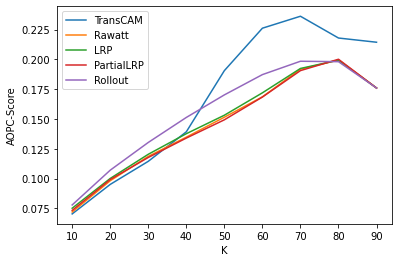

In [68]:
x = [10,20,30,40,50,60,70,80,90]
#AOPC masked values
plt.plot(x, aopc_TransCAM, label="TransCAM")
plt.plot(x, aopc_Rawatt, label ="Rawatt")
plt.plot(x, aopc_LRP, label = "LRP")
plt.plot(x, aopc_PartialLRP, label="PartialLRP")
plt.plot(x, aopc_Rollout, label="Rollout")
plt.xlabel("K")
plt.ylabel("AOPC-Score")
plt.legend()
plt.savefig("AOPC.pdf")

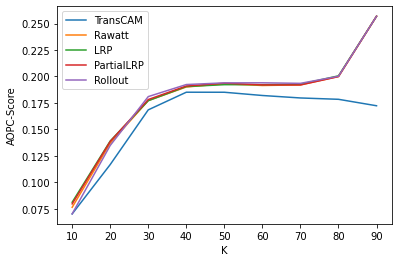

In [69]:
#AOPC delted values
plt.plot(x, aopc_TransCAM_del, label="TransCAM")
plt.plot(x, aopc_Rawatt_del, label ="Rawatt")
plt.plot(x, aopc_LRP_del, label = "LRP")
plt.plot(x, aopc_PartialLRP_del, label="PartialLRP")
plt.plot(x, aopc_Rollout_del, label="Rollout")
plt.xlabel("K")
plt.ylabel("AOPC-Score")
plt.legend()
plt.savefig("AOPC_del.pdf")

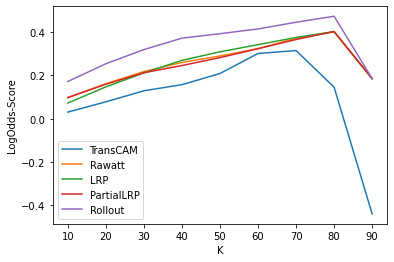

In [72]:
#Lodds masked values
plt.plot(x, logodds_TransCAM, label="TransCAM")
plt.plot(x, logodds_Rawatt, label ="Rawatt")
plt.plot(x, logodds_LRP, label = "LRP")
plt.plot(x, logodds_PartialLRP, label="PartialLRP")
plt.plot(x, logodds_Rollout, label="Rollout")
plt.xlabel("K")
plt.ylabel("LogOdds-Score")
plt.legend()
plt.savefig("logodds.pdf")

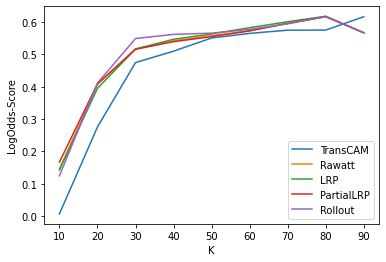

In [71]:
#Lodds del values
plt.plot(x, logodds_TransCAM_del, label="TransCAM")
plt.plot(x, logodds_Rawatt_del, label ="Rawatt")
plt.plot(x, logodds_LRP_del, label = "LRP")
plt.plot(x, logodds_PartialLRP_del, label="PartialLRP")
plt.plot(x, logodds_Rollout_del, label="Rollout")
plt.xlabel("K")
plt.ylabel("LogOdds-Score")
plt.legend()
plt.savefig("logodds_del.pdf")

# Single Example Visualization

In [22]:
def expln_norm(expln):
    expln = (expln - expln.min()) / (expln.max()- expln.min())
    return expln

def show_text_attr(expln,str_list,is_relu = True):
    if is_relu:
        rgb = lambda x: '0,0,0' if x < 0 else '0,255,0'
        alpha = lambda x: max(x, 0)* 10
    else:
        rgb = lambda x: '255,0,0' if x < 0 else '0,255,0'
        alpha = lambda x: x * -5 if x < 0 else x * 5
    attrs = list(expln)
    subwords = str_list
    
    token_marks = [
        f'<mark style="background-color:rgba({rgb(attr)},{alpha(attr)})">{token}</mark>'
        for token, attr in zip(subwords, attrs)
    ]
    
    display(HTML('<p>' + ' '.join(token_marks) + '</p>'))

In [34]:
input_ids, attention_mask, text_words, label = preprocess_sample(tokenized_mnli,index=13)

In [35]:
# initialize the explanations generator
explanations = Generator(model)

In [36]:
# TransCAM_expln, LRP_expln, PartialLRP_expln, FullLRP_expln, Att_expln, Rollout_expln, Att_Gradcam_expln = \
        # generate_explns(explanations, input_ids, attention_mask, start_layer=0, true_class = label, is_true = True) 
TransCAM_expln, LRP_expln, PartialLRP_expln, Att_expln, Rollout_expln = \
       generate_explns(explanations, input_ids, attention_mask, start_layer=0, true_class = label, is_true = True) 

In [38]:
#TransCAM_expln = expln_norm(TransCAM_expln)
show_text_attr(TransCAM_expln,text_words,is_relu = False)

None


In [39]:
#LRP_expln = expln_norm(LRP_expln)
show_text_attr(LRP_expln,text_words,is_relu = False)

In [86]:
#FullLRP_expln = expln_norm(FullLRP_expln)
show_text_attr(FullLRP_expln,text_words,is_relu = False)

NameError: name 'FullLRP_expln' is not defined

In [40]:
PartialLRP_expln = expln_norm(PartialLRP_expln)
show_text_attr(PartialLRP_expln,text_words,is_relu = False)

In [41]:
#Att_expln = expln_norm(Att_expln)
show_text_attr(Att_expln,text_words,is_relu = False)

In [42]:
Rollout_expln = expln_norm(Rollout_expln)
show_text_attr(Rollout_expln,text_words,is_relu = False)

In [36]:
Att_Gradcam_expln = expln_norm(Att_Gradcam_expln)
show_text_attr(Att_Gradcam_expln,text_words,is_relu = False)

NameError: name 'Att_Gradcam_expln' is not defined